# Zillow’s Home Value Prediction (Zestimate)

Zillow's Zestimate is created to give consumers as much information as possible about homes and the housing market, marking consumers had access to this type of home value information. It's based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. We will develop an algorithm to help push the accuracy of the Zestimate even further. 

Team members:
- 914507521 Jingxian Liao
- 914443957 Weizhuo Xiong
- 914521950 Mengye Liu

[Introduction](#Introduction)

1. [Data Description and Preprocession](#1.-Data-Description-and-Preprocession)
1. [Feature Selection](#2.-Feature-Selection)
1. [Regression Models](#3.-Regression-Models)
  1. [Simple Regression and Stacking](#3.1-Simple-Regression-and-Stacking)
    1. [Ridge regression](#3.1.1-Ridge-regression)
    1. [Random Forest](#3.1.2-Random-Forest)
    1. [Support Vector Machine](#3.1.3-SVM)
    1. [Model Stakcing](#3.1.4-Perform-Stacking-Method)
  1. [XGBoost model](#3.2-XGBOOST)
  1. [Neuro Network model](#3.3-Neuro-Network)
1. [Analysis and Comparison](#4.-Analysis-and-Comparision)
1. [Conclusion](#5.-Conclusions)

## Introduction

A home is often the largest and most expensive purchase a person makes in his or her lifetime. Ensuring homeowners have a trusted way to monitor this asset is incredibly important. The Zestimate was created to give consumers as much information as possible about homes and the housing market, marking the first time consumers had access to this type of home value information at no cost. For this competition, we  will develop an algorithm that makes predictions about the future sale prices of homes.

#### Global Imports

In [14]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np

import missingno as msno

import xgboost as xgb
from sklearn.preprocessing import scale
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from sklearn.svm import SVR
import itertools
from sklearn.model_selection import KFold, cross_val_score
plt.style.use('ggplot')
%matplotlib inline

## 1. Data Description and Preprocession

The dataset we used is provided by [Zillow price](#https://www.kaggle.com/c/zillow-prize-1#description). The response variable is logerror, which is defined as $logerror = \log(Zestimate)-\log(SalePrice)$. There are 58 predictor variables available to be chosen. Some of them are qualitative variables, and there's heavy missing value situation in lots of variables. Here, we will do some explorative work for furthur modelling.

The part will cover following topics.
  - Basic information 
  - [Missing Value Analysis](#1.2-Missing-value-analysis)
  - [Correlation Analysis](#1.3-Correlation-Analysis)
  - [Univariate Analysis](#1.4-Univariate-Analysis) 

#### 1.1 load data

In [3]:
train_df = pd.read_csv("originalinput/train_2016.csv", parse_dates=["transactiondate"])
properties = pd.read_csv('originalinput/properties_2016.csv')

/Users/thalia/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
train_df.tail()

,parcelid,logerror,transactiondate
90806,12046695,0.0070,2016-12-30
90807,12995401,-0.2679,2016-12-30
90808,11402105,0.0602,2016-12-30
90809,12566293,0.4207,2016-12-30
90810,10821829,0.1371,2016-12-30


In [6]:
train_df.shape, properties.shape

((90811, 3), (2985217, 58))

The train dataset includes 90811 housing trade records from 2016-01-01 to 2016-12-30. In the same time the test datset date is from 2016-10 to 2017-12. The property datatable includes 298517 properties in three places:.... So we neeed to merge the property into train_df to find the correspoinding predictor information.

In [7]:
train_df = pd.merge(train_df, properties, on='parcelid', how='left')
train_df.head()

,parcelid,logerror,transactiondate,month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.0,NaN,NaN,2.0,3.0,NaN,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,1,NaN,NaN,NaN,3.5,4.0,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1,1.0,NaN,NaN,3.0,2.0,NaN,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1,1.0,NaN,NaN,2.0,2.0,NaN,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,1,NaN,NaN,NaN,2.5,4.0,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


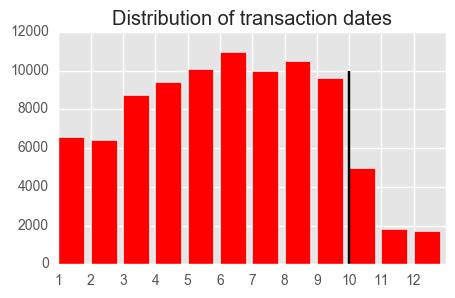

In [4]:
train_df['month']=[a.month for a in train_df['transactiondate']]
monthcount = train_df.groupby(train_df['month']).count()['logerror']
month = np.arange('2016-01', '2017-01', dtype='datetime64[M]')
fig, ax = plt.subplots(figsize=(5,3))
ax.bar(range(1,13),monthcount,color='red')
ax.vlines(10,0,10000)
ax.set_xlim(1,13)
ax.set_xticks(range(1,13))
ax.set_title("Distribution of transaction dates")

We draw a barplot to see the monthly trade frequency of our dataset. Obviously there are much fewer training data from Oct 2016 to Dec 2016, because they split part of them as test data. The transaction number of first two months are less than other months, which implies the time tendency of housing transaction.

#### 1.2 Missing value analysis

In [8]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / train_df.shape[0]
deletecolumn = missing_df[missing_df['missing_ratio']>0.25]["column_name"]
#deletecolumns are the columns whose data is missing more than 25%.

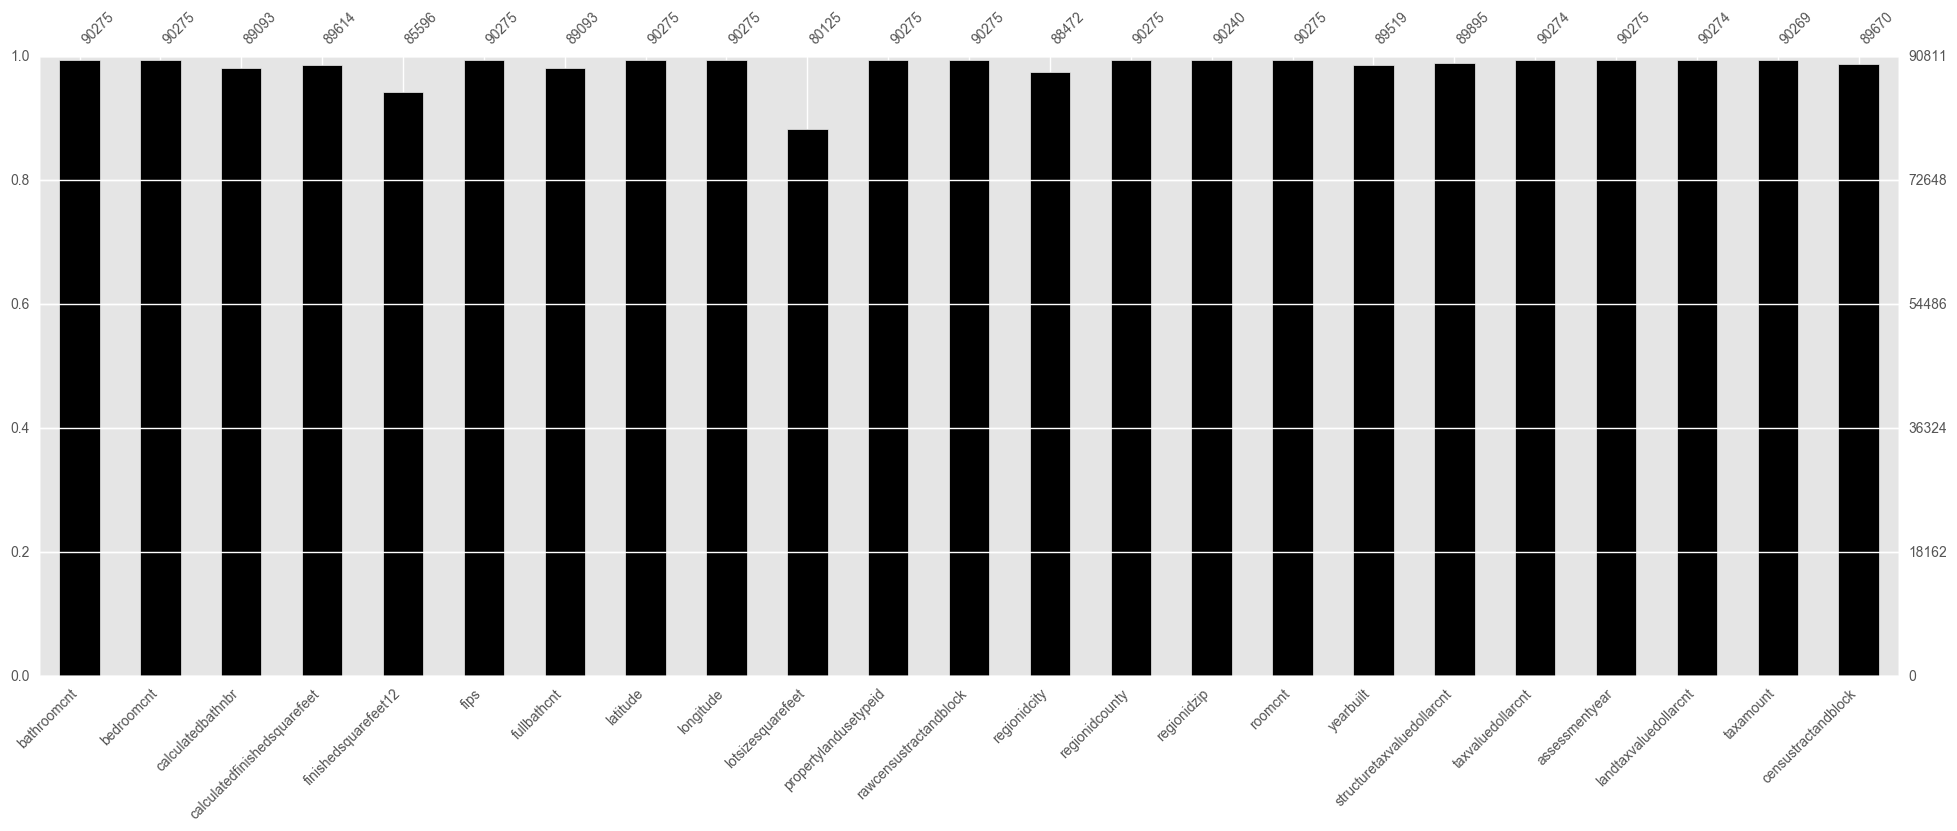

In [9]:
#missing ratio of variables chosen
usetrain_df =  train_df[['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock']]
missingValueColumns = usetrain_df.columns[usetrain_df.isnull().any()].tolist()
msno.bar(usetrain_df[missingValueColumns],\
            figsize=(24,8),color='black',fontsize=10)

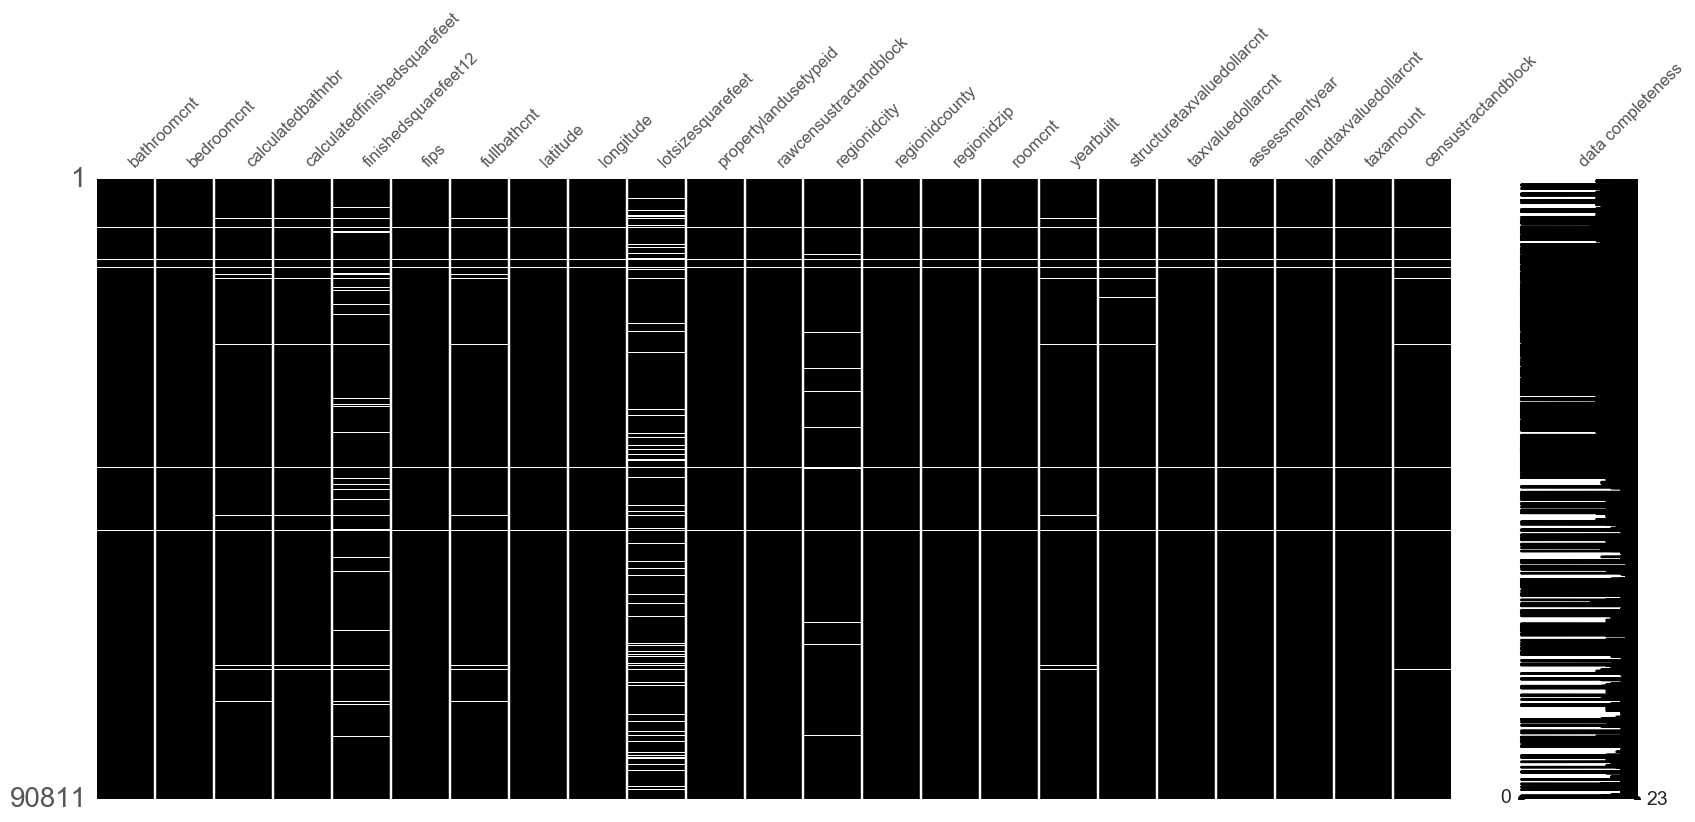

In [10]:
msno.matrix(usetrain_df[missingValueColumns],width_ratios=(10,1),\
            figsize=(20,8),color=(0,0, 0),fontsize=12,sparkline=True,labels=True)

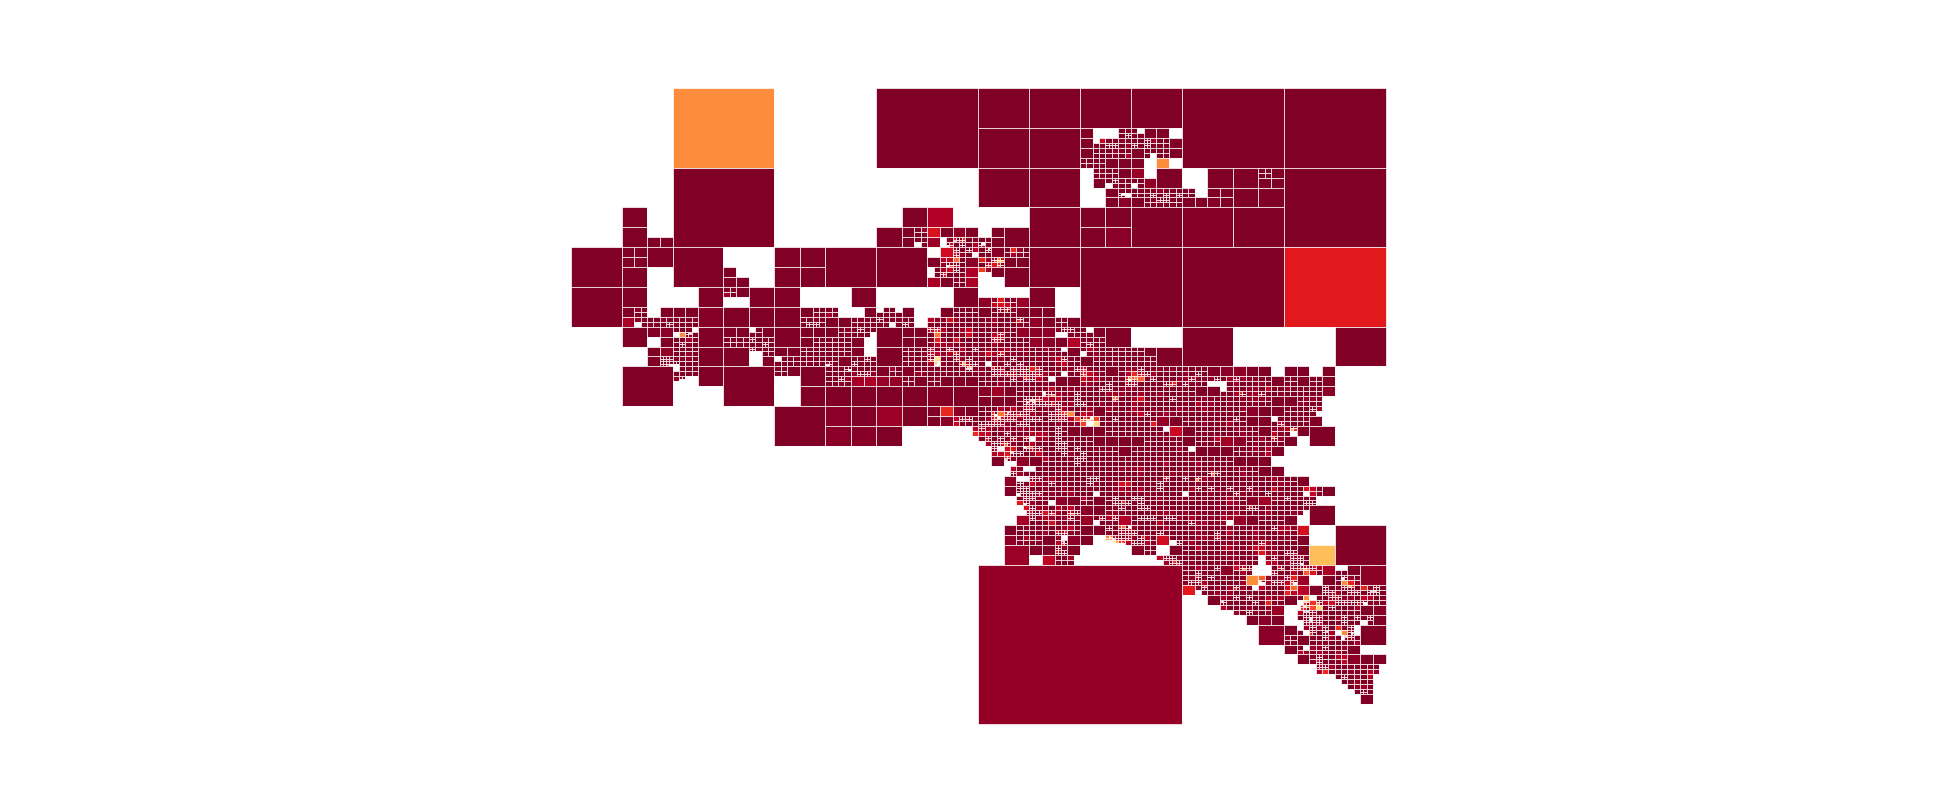

In [11]:
msno.geoplot(usetrain_df, x='longitude', y='latitude')

We decide to give up variables whose missing ratio is more than 25%. Here, we just show the missing data pattern in variables that we choose. The first plot shows the missing rate of these variables, whose black part means data exist. Based on the visualization of data missing situation with records, there's some pattern about missing between variables in plot 2. In many records, value of variables are missing together, like 'finishedsquarefeet12' and 'lotsizesquarefeet'. So we can't simply impute data according to their own distribution. We also draw the geographical graph about missing situation. It automatically splits the dataset into statistically significant chunks and colorizes them based on the average nullity of data points within them. Later we will compare and find the best way to impute rest missing data.

#### 1.3 Correlation Analysis

Here we will explore the relationship between some important variables. These variables are gotten through XGBoost Regression from an initial experimental model which includes all variables left.

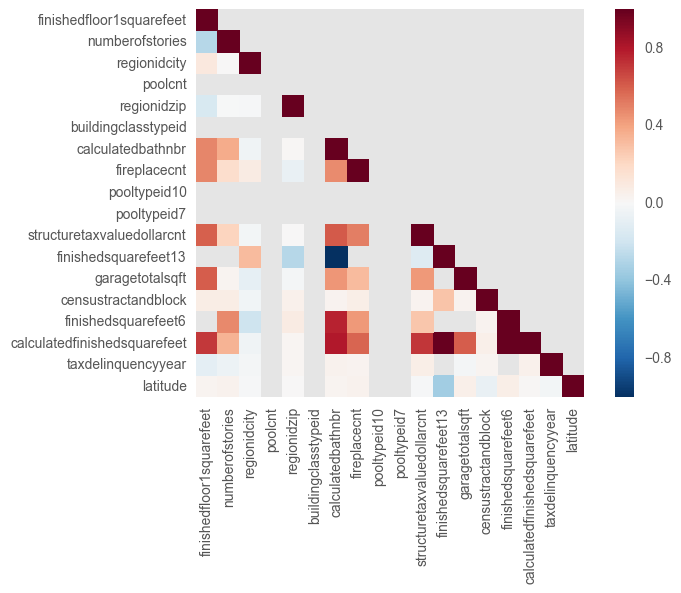

In [12]:
corrMatt = train_df[['finishedfloor1squarefeet','numberofstories','regionidcity','poolcnt','regionidzip',
 'buildingclasstypeid','calculatedbathnbr','fireplacecnt','taxdelinquencyflag','pooltypeid10',
 'pooltypeid7','structuretaxvaluedollarcnt','propertyzoningdesc','finishedsquarefeet13',
 'garagetotalsqft','censustractandblock','finishedsquarefeet6','calculatedfinishedsquarefeet',
 'taxdelinquencyyear','latitude']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(8,5)
sns.heatmap(corrMatt, mask=mask,vmax=.4, square=True)

From this correlation matrix, some important variables are positive related. So we need to use Lasso or other penalty function to reduce this multicolinearity effect.

#### 1.4 Univariate Analysis

First, let's look at the distribution of response variable -- logerror. Removing the influence of outliners, this histogram shows that logerror has a nice normal like distribution, which fits the assumption of the linear regression model. This datset only includes trade records for 1 year. There may exists a seasonal effect in the logerror. But considering the period, we won't use this information to train our model.

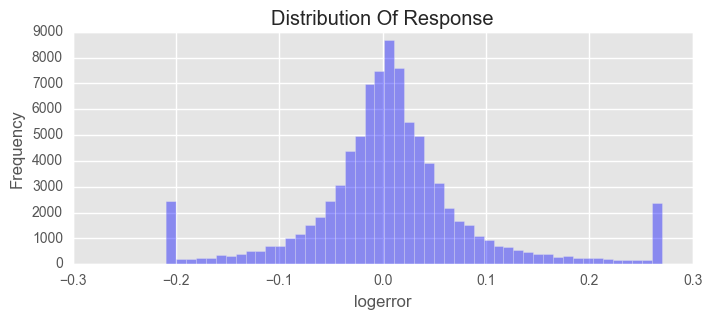

In [195]:
#upper = np.percentile(train_df.logerror.values, 97.5)
#lower = np.percentile(train_df.logerror.values, 2.5)
train_df['logerror'].loc[train_df['logerror']>upper] = upper
train_df['logerror'].loc[train_df['logerror']<lower] = lower

fig,ax = plt.subplots()
fig.set_size_inches(8,3)
sns.distplot(train_df.logerror.values, bins=50,kde=False,color="blue",ax=ax)
ax.set(xlabel='logerror', ylabel='Frequency',title="Distribution Of Response")

 None]

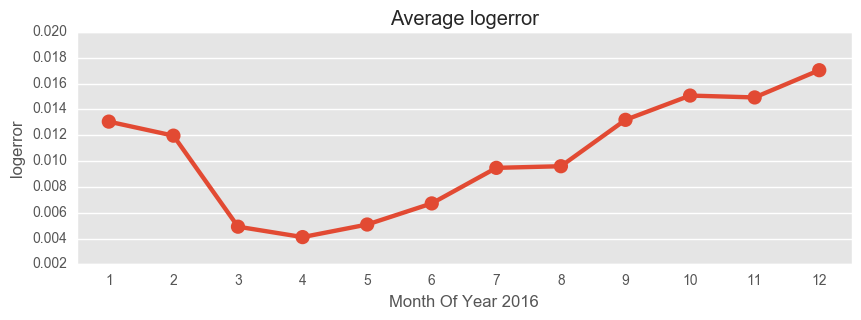

In [204]:
traingroupedMonth = train_df.groupby(["month"])["logerror"].mean().to_frame().reset_index()
fig,ax1= plt.subplots()
fig.set_size_inches(10,3)
sns.pointplot(x=traingroupedMonth["month"], y=traingroupedMonth["logerror"], data=traingroupedMonth, join=True)
ax1.set(xlabel='Month Of Year 2016', ylabel='logerror',title="Average logerror",label='big')

## 2. Feature Selection

Based on the result of explorative variable analysis, we already know that our response variable is normal-like distributed. And We select predictors whose missing rate is less than 25% roughly. Now we want to deal with our X variables: factorize categorical variables, figure out the importance of these variables and then select some of them as our final predictors.

After checking the meaning of these variables, the following variables are cateogircal: fips, propertylandusetypeid, regionidcounty. There are only three values in regionidcounty: 3101,1286 and 2061. So we just factorise it as 0,1 and 2. The value of propertyliandsetypeid are meaningless. And there are so many unique values, we need to sort them into larger classes based on their meanings and frequencies. And then, we use oneencode method to make them as dummy variables. Consider the property of fips(Federal Information Processing Standard code),we try to use this code to get the geography information of these properties.

To figure out the relationship between logerror and other variables, we use xgboost model to see the importance of these variables. We use correlation matrix to see whether some variables are basically independent with logerror in the beginning, but the result shows that their correlations with logerror are so similar that we can't tell which one is larger. So, we use this way to do some digging. The code part is very similar as the xgboost model we build, therefore we omit them and simply explain the result. Here the dataset we use includes all the variables in case some extremely important variables will be omitted by the rough selection. All the missing values are filled as -999. The first 10 important variables are 'finishedfloor1squarefeet','numberofstories','regionidcity','poolcnt','regionidzip','buildingclasstypeid','calculatedbathnbr','fireplacecnt','taxdelinquencyflag','pooltypeid10'. These variables involves different aspects of housing situations, like location, housewares, housing size, interior design, etc. We will consider these situations when we choose our final features.

## 3. Regression Models

### 3.1 Simple Regression and Stacking

For this part, we use three different regression method: ridge, randomforest, support vector machine to train the model, then we using the stacking method to combine them together. For the dataset, we fill missing data with mode since which will provide the best prediciton. For each seperate regression method, we use grid search cross validation to find the best parameters that are needed in final model. The best parameters are shown below, when we upload the predicted value, the logerror returned is  0.0870198.

Ridge||RandomForest||SVM||
---- | ---|---|---|---|---|
_parameter_ | _value_|_parameter_ | _value_|_parameter_ | _value_
alpha| 1|max_depth |14|bandwidth|8.07e-05
 ||max_leaf_nodes|400||
 ||min_samples_leaf | 1||
||min_sample_split | 5||

In [31]:
X = pd.read_table('adjustedinput/mode/x_train_mode.csv',sep=',')
X = X.iloc[:,1:]
y = pd.read_csv('adjustedinput/train_y.csv')
X_train = scale(X)
y_train = np.array(y).ravel()

#### 3.1.1 Ridge regression

In [ ]:
ridge_test = {
 'alpha':[1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10,30,50,100]}
gsearch = GridSearchCV(estimator = Ridge(), 
param_grid = ridge_test,n_jobs=4,iid=False, cv=5,scoring='neg_mean_squared_error')
gsearch.fit(X_train,y_train)
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

#### 3.1.2 Random Forest

__1)__ Tune Max_depth and max_leaf_node

In [3]:
maxd, maxleaf, scores = [], [], []
for i,j in itertools.product(range(2,10,2),[10,50,100,200,500]):
    RFC=RandomForestRegressor(max_depth=i,max_leaf_nodes=j, min_samples_leaf=1,
                           min_samples_split=2,min_weight_fraction_leaf=0.0,oob_score=True)
    score = RFC.fit(X_train,y_train).oob_score_
    maxd.append(i); maxleaf.append(j);scores.append(abs(score))
    print('max_depth:',i,'max_leaf_nodes:',j,'score:%.4f'%abs(score))
index=np.argmax(scores)
print('best:','max_depth:',maxd[index],'max_leaf_nodes:',maxleaf[index],'score',scores[index])

/Users/thalia/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


('max_depth:', 2, 'max_leaf_nodes:', 10, 'score:0.0059')
('max_depth:', 2, 'max_leaf_nodes:', 50, 'score:0.0007')
('max_depth:', 2, 'max_leaf_nodes:', 100, 'score:0.0036')
('max_depth:', 2, 'max_leaf_nodes:', 200, 'score:0.0094')
('max_depth:', 2, 'max_leaf_nodes:', 500, 'score:0.0037')
('max_depth:', 4, 'max_leaf_nodes:', 10, 'score:0.0179')
('max_depth:', 4, 'max_leaf_nodes:', 50, 'score:0.0139')
('max_depth:', 4, 'max_leaf_nodes:', 100, 'score:0.0069')
('max_depth:', 4, 'max_leaf_nodes:', 200, 'score:0.0051')
('max_depth:', 4, 'max_leaf_nodes:', 500, 'score:0.0151')
('max_depth:', 6, 'max_leaf_nodes:', 10, 'score:0.0070')
('max_depth:', 6, 'max_leaf_nodes:', 50, 'score:0.0154')
('max_depth:', 6, 'max_leaf_nodes:', 100, 'score:0.0121')
('max_depth:', 6, 'max_leaf_nodes:', 200, 'score:0.0103')
('max_depth:', 6, 'max_leaf_nodes:', 500, 'score:0.0144')
('max_depth:', 8, 'max_leaf_nodes:', 10, 'score:0.0153')
('max_depth:', 8, 'max_leaf_nodes:', 50, 'score:0.0335')
('max_depth:', 8, 'max

the answer show that for both value, the higher the node and depth, the better the performance, in order to find the optimal one, I will try to set higher value.

In [116]:
maxd, maxleaf, scores = [], [], []
for i,j in itertools.product(range(8,20,3),[150,200,250,300,400]):
    RFC=RandomForestRegressor(max_depth=i,max_leaf_nodes=j, min_samples_leaf=1,
                           min_samples_split=2,min_weight_fraction_leaf=0.0,oob_score=True)
    score = RFC.fit(X_train,y_train).oob_score_
    maxd.append(i); maxleaf.append(j);scores.append(abs(score))
    print('max_depth:',i,'max_leaf_nodes:',j,'score:%.4f'%abs(score))
index=np.argmax(scores)
print('best:','max_depth:',maxd[index],'max_leaf_nodes:',maxleaf[index],'score',scores[index])

/Users/thalia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('max_depth:', 8, 'max_leaf_nodes:', 150, 'score:0.0162')
('max_depth:', 8, 'max_leaf_nodes:', 200, 'score:0.0240')
('max_depth:', 8, 'max_leaf_nodes:', 250, 'score:0.0114')
('max_depth:', 8, 'max_leaf_nodes:', 300, 'score:0.0092')
('max_depth:', 8, 'max_leaf_nodes:', 400, 'score:0.0297')
('max_depth:', 11, 'max_leaf_nodes:', 150, 'score:0.0442')
('max_depth:', 11, 'max_leaf_nodes:', 200, 'score:0.0481')
('max_depth:', 11, 'max_leaf_nodes:', 250, 'score:0.0538')
('max_depth:', 11, 'max_leaf_nodes:', 300, 'score:0.0401')
('max_depth:', 11, 'max_leaf_nodes:', 400, 'score:0.0296')
('max_depth:', 14, 'max_leaf_nodes:', 150, 'score:0.0506')
('max_depth:', 14, 'max_leaf_nodes:', 200, 'score:0.0566')
('max_depth:', 14, 'max_leaf_nodes:', 250, 'score:0.0483')
('max_depth:', 14, 'max_leaf_nodes:', 300, 'score:0.0468')
('max_depth:', 14, 'max_leaf_nodes:', 400, 'score:0.1045')
('max_depth:', 17, 'max_leaf_nodes:', 150, 'score:0.0525')
('max_depth:', 17, 'max_leaf_nodes:', 200, 'score:0.0664')
('

the answer show that the best max_depth is 14, and best max_leaf_nodes are 400.

__2)__ Tune min_samples_leaf and min_samples_spl

using the best parameter for best max_depth and best max_leaf_nodes, we can continually tune other parameters.

In [235]:
minleaf, minsplit, scores = [], [], []
for i,j in itertools.product([1,10,30],[2,5,10,50]):
    RFC=RandomForestRegressor(max_depth=14,max_leaf_nodes=400, min_samples_leaf=i,
                           min_samples_split=j,min_weight_fraction_leaf=0.0,oob_score=True)
    score = RFC.fit(X_train,y_train).oob_score_
    minleaf.append(i); minsplit.append(j);scores.append(abs(score))
    print('min_samples_leaf:',i,'min_samples_spl:',j,'score',"%.6f"%abs(score))
index=np.argmax(scores)
print('best:','min_samples_leaf:',minleaf[index],'min_samples_spl:',minsplit[index],'score',scores[index])

('min_samples_leaf:', 1, 'min_samples_spl:', 2, 'score', '0.055720')
('min_samples_leaf:', 1, 'min_samples_spl:', 5, 'score', '0.057621')
('min_samples_leaf:', 1, 'min_samples_spl:', 10, 'score', '0.042945')
('min_samples_leaf:', 1, 'min_samples_spl:', 50, 'score', '0.023573')
('min_samples_leaf:', 10, 'min_samples_spl:', 2, 'score', '0.018856')
('min_samples_leaf:', 10, 'min_samples_spl:', 5, 'score', '0.013443')
('min_samples_leaf:', 10, 'min_samples_spl:', 10, 'score', '0.018737')
('min_samples_leaf:', 10, 'min_samples_spl:', 50, 'score', '0.009663')
('min_samples_leaf:', 30, 'min_samples_spl:', 2, 'score', '0.000011')
('min_samples_leaf:', 30, 'min_samples_spl:', 5, 'score', '0.002220')
('min_samples_leaf:', 30, 'min_samples_spl:', 10, 'score', '0.000613')
('min_samples_leaf:', 30, 'min_samples_spl:', 50, 'score', '0.002870')
('best:', 'min_samples_leaf:', 1, 'min_samples_spl:', 5, 'score', 0.057621366975735278)


best parameter for random forest:
1. max_depth is 14 
2. max_leaf_nodes is 400
3. min_samples_leaf is 1
4. min_sample_split is 5

#### 3.1.3 SVM

In [9]:
import hpsklearn
from hpsklearn import HyperoptEstimator, svc
from hyperopt import tpe
from sklearn.svm import SVR

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [10]:
X_train = X_train.astype('float64')
y_train = y_train.astype('float64')

In [11]:
mysvr = SVR()
estim = HyperoptEstimator( regressor =hpsklearn.components.svr('mysvr'), 
                            algo=tpe.suggest, trial_timeout=100)
estim.fit(X_train,y_train)

In [12]:
estim.best_model()

{'ex_preprocs': (),
 'learner': SVR(C=8.07639000981e-05, cache_size=512, coef0=0.0, degree=1,
   epsilon=561.857419396, gamma='auto', kernel='linear',
   max_iter=76417421.0, shrinking=False, tol=0.00924829940784,
   verbose=False),
 'preprocs': (StandardScaler(copy=True, with_mean=False, with_std=True),)}

#### 3.1.4 Perform Stacking Method

In [13]:
from mlxtend.regressor import StackingRegressor

In [15]:
ridge = Ridge(alpha=1)
svr = SVR(C=8.07639000981e-05, cache_size=512, coef0=0.0, degree=1,
   epsilon=561.857419396, gamma='auto', kernel='linear',
   max_iter=76417421.0, shrinking=False, tol=0.00924829940784,
   verbose=False)
rf = RandomForestRegressor(max_depth=14,max_leaf_nodes=400, min_samples_leaf=1,
                           min_samples_split=5)
stregr = StackingRegressor(regressors=[ridge,rf],meta_regressor=svr)
stregr.fit(X_train, y_train)
ypred = stregr.predict(X_test)

print("Mean Squared Error: %.4f"% np.mean((ypred - y_test) ** 2))

Mean Squared Error: 0.0329


In [16]:
test = pd.read_table('originalinput/sample_submission.csv',sep=',')
test_df_remaining = pd.read_table("adjustedinput/mode/test_df_remaining_mode.csv",sep=',')
test_df_remaining = test_df_remaining.iloc[:,1:]

In [15]:
test_df_remaining.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,...,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,0.0,0.0,2.0,1572.0,1539.0,6037.0,2.0,34144442.0,-118654084.0,85768.0,...,3101.0,96337.0,0.0,1963.0,122590.0,9.0,2015.0,9.0,3991.78,6.037572e+13
1,0.0,0.0,2.0,1572.0,1539.0,6037.0,2.0,34140430.0,-118625364.0,4083.0,...,3101.0,96337.0,0.0,1963.0,122590.0,27516.0,2015.0,27516.0,3991.78,6.037572e+13
2,0.0,0.0,2.0,73026.0,1539.0,6037.0,2.0,33989359.0,-118394633.0,63085.0,...,3101.0,96095.0,0.0,1963.0,650756.0,1413387.0,2015.0,762631.0,20800.37,6.037572e+13
3,0.0,0.0,2.0,5068.0,1539.0,6037.0,2.0,34148863.0,-118437206.0,7521.0,...,3101.0,96424.0,0.0,1948.0,571346.0,1156834.0,2015.0,585488.0,14557.57,6.037572e+13
4,0.0,0.0,2.0,1776.0,1539.0,6037.0,2.0,34194168.0,-118385816.0,8512.0,...,3101.0,96450.0,0.0,1947.0,193796.0,433491.0,2015.0,239695.0,5725.17,6.037572e+13


In [ ]:
#estimate reponse variable in test data
y_predict_stack = stregr.predict(test_df_remaining)
for i in range(1,7):
    test.iloc[:,i]=y_predict_stack

### 3.2 XGBOOST

For this part, we firstly fill the missing data with three different value, the mean, median and mode. Then, for all these dataset, we use grid search cross validation to find the best parameters one by one. We only provide the training process of fill-with-median model here. The best parameter for each model and predcition value are listed below, the answer show that fill missing value with mode will provide the best answer.

|Mean|Median|Mode
---- | ---|---|---
learning_rate|0.1|0.1|0.1
n_estimators|140|1000|140
max_depth|5|5|5
min_child_weight|6.5|6|8.5
gamma|0|0.1|0.01
subsample|0.85|0.85|0.8
colsample_bytree|0.85|0.85|0.75
reg_alpha|5|5|1
reg_lambda|100|50|500
scale_pos_weight|1|1|1
__logerror__|0.0660177|0.0673185|0.0657067

In [11]:
def feat_imp_plot(xgbmodel):
    plt
    xgbmodel.fit(train[predictors], train[target],eval_metric='auc')
    feat_imp = pd.Series(xgbmodel.booster().get_fscore()).sort_values(ascending=False)
    plt.figure(figsize=(15,5))
    #feat_imp = pd.Series(xgb1.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [3]:
train = pd.read_table("x_train_mode.csv",sep=',')
y = pd.read_table("train_y.csv",sep=',')
train['logerror']=y.iloc[:,0]
target = 'logerror'
train = train.iloc[:,1:]
predictors = [x for x in train.columns if x not in [target]]

In [4]:
train.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,...,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror
0,2.0,3.0,2.0,1684.0,1684.0,6037.0,2.0,34280990.0,-118488536.0,7528.0,...,96370.0,0.0,1959.0,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13,0.0276
1,3.5,4.0,3.5,2263.0,2263.0,6059.0,3.0,33668120.0,-117677556.0,3643.0,...,96962.0,0.0,2014.0,346458.0,585529.0,2015.0,239071.0,10153.02,6.037920e+13,-0.1684
2,3.0,2.0,3.0,2217.0,2217.0,6037.0,3.0,34136312.0,-118175032.0,11423.0,...,96293.0,0.0,1940.0,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13,-0.0040
3,2.0,2.0,2.0,839.0,839.0,6037.0,2.0,33755800.0,-118309000.0,70859.0,...,96222.0,0.0,1987.0,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13,0.0218
4,2.5,4.0,2.5,2283.0,2283.0,6059.0,2.0,33485643.0,-117700234.0,6000.0,...,96961.0,8.0,1981.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13,-0.0050


#### 3.2.1 Tune max_depth and min_child_weight

We tune these first as they will have the highest impact on model outcome. To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges.

In [23]:
param_test1 = {
 'max_depth':list(range(3,10,2)),
 'min_child_weight':list(range(1,6,2))
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/Users/thalia/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.02657, std: 0.00415, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.02644, std: 0.00419, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.02643, std: 0.00420, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.02663, std: 0.00420, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.02647, std: 0.00420, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.02640, std: 0.00421, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.02680, std: 0.00413, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.02659, std: 0.00421, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.02644, std: 0.00423, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.02704, std: 0.00407, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -0.02678, std: 0.00409, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.02663, std: 0.00411, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_chil

Here, we have run 12 combinations with wider intervals between values. The ideal values are 3 for max_depth and 3 for min_child_weight. Lets go one step deeper and look for optimum values. We’ll search for values 2 below the optimum values because I find there exist the trend of lower the best.

In [25]:
param_test2 = {
 'max_depth':[3,4,5,6,7],
 'min_child_weight':[3,4,5,6,7]
}
gsearch2 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

/Users/thalia/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.02644, std: 0.00419, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.02643, std: 0.00417, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: -0.02643, std: 0.00420, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.02643, std: 0.00417, params: {'max_depth': 3, 'min_child_weight': 6},
  mean: -0.02641, std: 0.00421, params: {'max_depth': 3, 'min_child_weight': 7},
  mean: -0.02646, std: 0.00421, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: -0.02645, std: 0.00419, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: -0.02642, std: 0.00422, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: -0.02640, std: 0.00423, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: -0.02640, std: 0.00422, params: {'max_depth': 4, 'min_child_weight': 7},
  mean: -0.02647, std: 0.00420, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.02641, std: 0.00424, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: -0.02640, std: 0.004

Here, we get the optimum values as 5 for max_depth and 6 for min_child_weight

#### 3.2.2 Tune gamma 

Now lets tune gamma value using the parameters already tuned above. Gamma can take various values but I’ll check for 5 values here. You can go into more precise values as.

In [28]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

/Users/thalia/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.02639, std: 0.00420, params: {'gamma': 0.0},
  mean: -0.02637, std: 0.00424, params: {'gamma': 0.1},
  mean: -0.02642, std: 0.00423, params: {'gamma': 0.2},
  mean: -0.02642, std: 0.00426, params: {'gamma': 0.3},
  mean: -0.02642, std: 0.00428, params: {'gamma': 0.4}],
 {'gamma': 0.1},
 -0.026373669567036039)

This shows that our original value of gamma, i.e. 0.1 is the optimum one. Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.
so the best parameters for now is :

1. max_depth:5
2. min_child_weight:6 
3. gamma:0.1

#### 3.2.3 Tune subsample and colsample_bytree

The next step would be try different subsample and colsample_bytree values. Lets do this in 2 stages as well and take values 0.6,0.7,0.8,0.9 for both to start with.

In [5]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

/Users/thalia/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.02641, std: 0.00420, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: -0.02640, std: 0.00417, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: -0.02639, std: 0.00422, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: -0.02643, std: 0.00416, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: -0.02641, std: 0.00422, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: -0.02641, std: 0.00418, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: -0.02639, std: 0.00421, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: -0.02642, std: 0.00420, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: -0.02642, std: 0.00419, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: -0.02640, std: 0.00420, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: -0.02637, std: 0.00424, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: -0.02641, std: 0.00414, params: {'subsample': 0.9, 'colsa

Here, we found 0.8,0.8 as the optimum value for both subsample and colsample_bytree. Now we should try values in 0.05 interval around these.

In [6]:
param_test5 = {
 'subsample':[i/100.0 for i in range(70,95,5)],
 'colsample_bytree':[i/100.0 for i in range(70,95,5)]
}
gsearch5 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

/Users/thalia/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.02641, std: 0.00418, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: -0.02643, std: 0.00423, params: {'subsample': 0.75, 'colsample_bytree': 0.7},
  mean: -0.02639, std: 0.00421, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: -0.02639, std: 0.00422, params: {'subsample': 0.85, 'colsample_bytree': 0.7},
  mean: -0.02642, std: 0.00420, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: -0.02640, std: 0.00421, params: {'subsample': 0.7, 'colsample_bytree': 0.75},
  mean: -0.02641, std: 0.00423, params: {'subsample': 0.75, 'colsample_bytree': 0.75},
  mean: -0.02644, std: 0.00424, params: {'subsample': 0.8, 'colsample_bytree': 0.75},
  mean: -0.02638, std: 0.00421, params: {'subsample': 0.85, 'colsample_bytree': 0.75},
  mean: -0.02639, std: 0.00414, params: {'subsample': 0.9, 'colsample_bytree': 0.75},
  mean: -0.02640, std: 0.00420, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: -0.02642, std: 0.00421, params: {'subsample': 0.

Then we got the optimum values are:
subsample: 0.85
colsample_bytree: 0.85

#### 3.2.4 Tuning Regularization Parameters

Next step is to apply regularization to reduce overfitting. 

In [8]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=6, gamma=0.1, subsample=0.85, colsample_bytree=0.85, nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

/Users/thalia/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.02642, std: 0.00417, params: {'reg_alpha': 1e-05, 'reg_lambda': 1e-05},
  mean: -0.02639, std: 0.00418, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.01},
  mean: -0.02640, std: 0.00421, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.1},
  mean: -0.02636, std: 0.00421, params: {'reg_alpha': 1e-05, 'reg_lambda': 1},
  mean: -0.02625, std: 0.00415, params: {'reg_alpha': 1e-05, 'reg_lambda': 100},
  mean: -0.02637, std: 0.00420, params: {'reg_alpha': 0.01, 'reg_lambda': 1e-05},
  mean: -0.02638, std: 0.00418, params: {'reg_alpha': 0.01, 'reg_lambda': 0.01},
  mean: -0.02640, std: 0.00423, params: {'reg_alpha': 0.01, 'reg_lambda': 0.1},
  mean: -0.02640, std: 0.00421, params: {'reg_alpha': 0.01, 'reg_lambda': 1},
  mean: -0.02625, std: 0.00416, params: {'reg_alpha': 0.01, 'reg_lambda': 100},
  mean: -0.02642, std: 0.00423, params: {'reg_alpha': 0.1, 'reg_lambda': 1e-05},
  mean: -0.02641, std: 0.00420, params: {'reg_alpha': 0.1, 'reg_lambda': 0.01},
  mean: -0.02643, std: 0.00420, 

the values tried are very widespread, we should try values closer to the optimum here (0.1) to see if we get something better.

In [10]:
param_test8 = {
 'reg_alpha':[0.2,0.5,0.7,1,2,5,10],
 'reg_lambda':[50,100,300,500]
}
gsearch8 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=6, gamma=0.1, subsample=0.85, colsample_bytree=0.85, nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test8, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch8.fit(train[predictors],train[target])
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

/Users/thalia/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.02627, std: 0.00416, params: {'reg_alpha': 0.2, 'reg_lambda': 50},
  mean: -0.02625, std: 0.00413, params: {'reg_alpha': 0.2, 'reg_lambda': 100},
  mean: -0.02625, std: 0.00413, params: {'reg_alpha': 0.2, 'reg_lambda': 300},
  mean: -0.02624, std: 0.00413, params: {'reg_alpha': 0.2, 'reg_lambda': 500},
  mean: -0.02627, std: 0.00415, params: {'reg_alpha': 0.5, 'reg_lambda': 50},
  mean: -0.02625, std: 0.00415, params: {'reg_alpha': 0.5, 'reg_lambda': 100},
  mean: -0.02625, std: 0.00413, params: {'reg_alpha': 0.5, 'reg_lambda': 300},
  mean: -0.02625, std: 0.00414, params: {'reg_alpha': 0.5, 'reg_lambda': 500},
  mean: -0.02625, std: 0.00415, params: {'reg_alpha': 0.7, 'reg_lambda': 50},
  mean: -0.02625, std: 0.00416, params: {'reg_alpha': 0.7, 'reg_lambda': 100},
  mean: -0.02624, std: 0.00413, params: {'reg_alpha': 0.7, 'reg_lambda': 300},
  mean: -0.02625, std: 0.00413, params: {'reg_alpha': 0.7, 'reg_lambda': 500},
  mean: -0.02625, std: 0.00415, params: {'reg_alpha': 1

You can see that we got a best value which are 5 and 50. Now we can apply this regularization in the model and look at the impact:

#### 3.2.5 Reducing Learning Rate adding more trees

Lastly, we should lower the learning rate and add more trees. Lets use the cv function of XGBoost to do the job again.

In [ ]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
 'reg_lambda':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1,random_state=27), 
 param_grid = param_test7, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

adding all tuned model below and show importance

#### 3.2.5 Fitting model

In [ ]:
xgb1 = XGBRegressor(
       learning_rate =0.1,
       n_estimators=1000,
       max_depth=5,
       min_child_weight=6,
       gamma=0.1,
       subsample=0.85,
       colsample_bytree=0.85,
       nthread=4,
       reg_alpha=5,
       reg_lambda=50,
       scale_pos_weight=1,
       seed=27)
xgb1.fit(train[predictors],train[target])

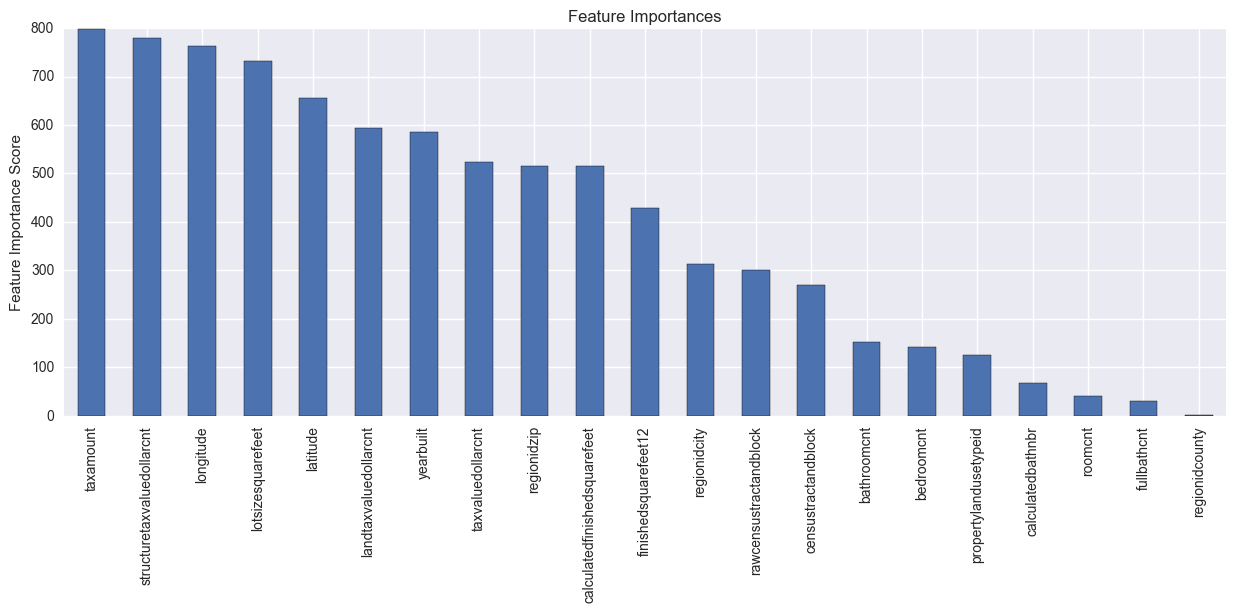

In [17]:
feat_imp = pd.Series(xgb1.booster().get_fscore()).sort_values(ascending=False)
plt.figure(figsize=(15,5))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

From the figure above, we can see that taxamount, structure tax value dollar count and the location of the house is very important for predict the logerror. However, there is another variable called region county has less importance, probably because the information it contains has been added into model by other variables which can convey location message.

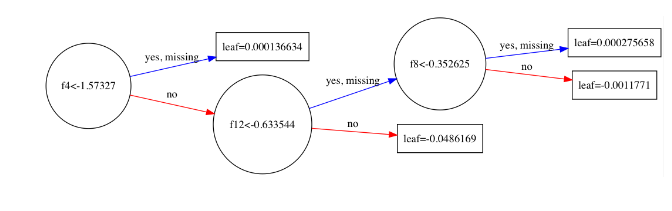

In [6]:
from sklearn.externals import joblib
median_xgb = joblib.load("xgb_median.m")
plt.show()
xgb.plot_tree(median_xgb, num_trees=0, rankdir='LR')

### 3.3 Neuro Network

This is the interestest part, we use TensorFlow to build a neuro network which has four hidden layer, each hidden layer has 20, 15 ,10, 5 neuro( the feature number is 24). We have tried different parameters, train iteration, and the answer show that with higher train itereation, the predicted answer will not perform better, and the prediciton value has logerror 0.067474, which does not ourperform XGBoost. We believe the reason is that neuro net work does not have obvious advantage when operate on simple problem, although the answer is good enough.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow.contrib import learn
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn import datasets, linear_model
from sklearn import cross_validation
import numpy as np

X_train, X_test, Y_train, Y_test =   train_test_split(X, y, test_size=0.2, random_state=42)
total_len = X_train.shape[0]

# Parameters
learning_rate = 0.001
training_epochs = 500
batch_size = 10
display_step = 1
dropout_rate = 0.9
# Network Parameters
n_hidden_1 = 20 # 1st layer number of features
n_hidden_2 = 15 # 2nd layer number of features
n_hidden_3 = 10
n_hidden_4 = 5
n_input = X_train.shape[1]
n_classes = 1

# tf Graph input
x = tf.placeholder("float", [None, 24])
y = tf.placeholder("float", [None])

# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)

    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)

    # Hidden layer with RELU activation
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.relu(layer_3)

    # Hidden layer with RELU activation
    layer_4 = tf.add(tf.matmul(layer_3, weights['h4']), biases['b4'])
    layer_4 = tf.nn.relu(layer_4)

    # Output layer with linear activation
    out_layer = tf.matmul(layer_4, weights['out']) + biases['out']
    return out_layer

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], 0, 0.1)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], 0, 0.1)),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3], 0, 0.1)),
    'h4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4], 0, 0.1)),
    'out': tf.Variable(tf.random_normal([n_hidden_4, n_classes], 0, 0.1))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1], 0, 0.1)),
    'b2': tf.Variable(tf.random_normal([n_hidden_2], 0, 0.1)),
    'b3': tf.Variable(tf.random_normal([n_hidden_3], 0, 0.1)),
    'b4': tf.Variable(tf.random_normal([n_hidden_4], 0, 0.1)),
    'out': tf.Variable(tf.random_normal([n_classes], 0, 0.1))
}

# Construct model
pred = multilayer_perceptron(x, weights, biases)
pred = tf.transpose(pred)
# Define loss and optimizer
cost = tf.reduce_mean(tf.square(pred-y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Launch the graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(total_len/batch_size)
        # Loop over all batches
        for i in range(total_batch-1):
            batch_x = X_train[i*batch_size:(i+1)*batch_size]
            batch_y = Y_train[i*batch_size:(i+1)*batch_size]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c, p = sess.run([optimizer, cost, pred], feed_dict={x: batch_x,
                                                          y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch

        # sample prediction
        label_value = batch_y
        estimate = p
        err = label_value-estimate

    print ("Optimization Finished!")
    predicted_vals = sess.run(pred, feed_dict={x: X_test})

Optimization Finished!
[[ 0.01018044 -0.03964762  0.03540372 ..., -0.05674762 -0.02914762 -0.01154762]]
MSE: 0.0330082)


## 4. Analysis and Comparision

In this project, we have tried 3 methods. The one having best results is XGboost with missing value filled by mode. This dataset is from Kaggle and we donot have the true response of test dataset. So we can just using the score which is given by Kaggle Website after uploading our predictions to get the accuracy of models.

- For the first method, we stack three simple regression models: ridge, svm and randomforest. We use different kernel here: Ridge is based on the idea that the variables are linear related; the kernel of SVM is sigmoid; and Random Forest is a meta estimator of decision tree regressor. We hope that the cross validation of constructing second layer data could help us to fit better. But unfortunately, the stacking model performs not satisfying as we think. More often than not the reason might be found in our original models. They may train and learn the same parts of information in our dataset, and many other important information is lost.

- For the second one, we have tried XGboost on three different datasets whose difference is using different methods to fill the missing value. The regression function is linear one. After tuning parameters, the best one is mode. What's more, it is also the best one among these three methods.
 -  For the method by using mean, it may have problem with some categorical variables, for example, we cannot interpret the meaning of 2.7 bedrooms. As for median, it may be a better estimator for cluster trend when extreme value exists but in this case, many data values are very closed so if we use mode the probability of getting a wrong number is smaller than other two method in terms of the posterior probability.
 - XGBoos is an ensamble method it uses many trees to take a decision so it gains power by repeating itself. It can take a huge advantage in a fight by creating thousands of trees. Gradient boosting requires much more care in setting up， so it is pretty much meaningless to train xgboost without cross-validation, so at most time xgboost has the better performance when compared with random forest.

- For the third one, We have tried different parameters, train iteration, and the answer show that with higher train itereation, the predicted answer will not perform better, and the prediciton value has logerror 0.067474, which does not outperform XGBoost. We believe the reason is that neuro net work does not have obvious advantage when operate on simple problem, although the answer is good enough.

## 5. Conclusions

Finally, we choose 21 features and XGboost with mode filling missing data. Its tuned parameters are showed in part 3.2 and its barplot for the importance of features as well as XGboost tree are showed below.

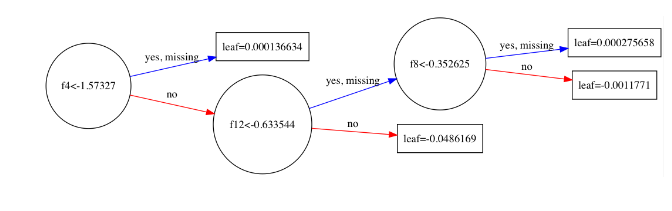

In [9]:
from sklearn.externals import joblib
mode_xgb = joblib.load("xgb_final.m")
plt.show()
xgb.plot_tree(mode_xgb, num_trees=0, rankdir='LR')

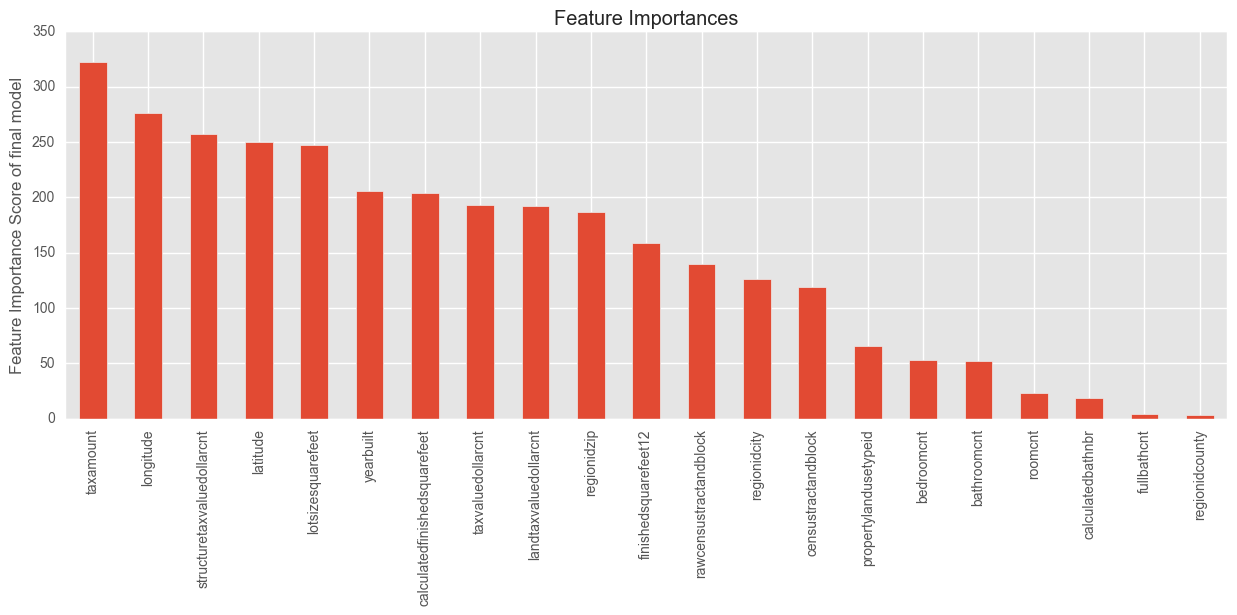

In [34]:
feat_imp = pd.Series(mode_xgb.booster().get_fscore()).sort_values(ascending=False)
plt.figure(figsize=(15,5))
#feat_imp = pd.Series(xgb1.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score of final model')

from the feature importance plot we can find out that taxamount and structuretaxvaluedollar plays the most important role,  which pretty make sense, since the higher value price tend to have higher tax, so they are closely related. In addition, longitude, latitude and zip code also have high importance, the possible reason is that housing price in same area might be similar, so when the location is similar, the housing price prediction accuracy might similar too.